# Observing Etna Eruption 
  ( a simple exercise )


## Introduction 
In early spring 2017, Sicilian biggest volcano - Etna - awakened and erupted several times. In this exercise we will demonstrate how such events can be observed using satellite images. We will utilize imagery acquired from satellites Sentinel 2 and Landsat 8.

Before we start we need to set up two "technical" things:

1) The text and code you see here are written in Jupyter Notebook. You will need to "execute cells" to see satellite images. You can do that by clicking on the cell and then pressing "ctrl + Enter". 

2) We will use sentinelhub to download the data and you will need to set up your "instance_id" in the cell below. A provisional instance is already provided for your convenience but it will support only limited number of requests to avoid abuse. If you want to play around and request more data, you will need to create your own one. Check instructions here: https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html#Sentinel-Hub-account. 

In [1]:
# Insert your instance_id between '' bellow, so that it looks something like INSTANCE_ID = 'cfa6t1fd-b7d2-4as3-9521-d28bss5c50e0' 
# Then press "ctrl + Enter"
INSTANCE_ID = 'cf8091e5-2837-463e-b45d-8dc0b121cad7' 

<i>A text "In [\*]" before a cell indicates that the cell is being executed. When the "\*" turns into number, e.g. "In [3]" it means that the cell was successfully executed and you can see the results of execution below the cell.</i>


Back to Etna now. First we will import all python modules that we need and define a function to help us plot images nicely:

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataSource
import datetime
import numpy as np
import matplotlib.pyplot as plt
import requests as  r
import ipywidgets as widgets
from IPython.display import display

def plot_image(image, bbox, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1), extent=[bbox[0], bbox[2], bbox[1], bbox[3]])
    else:
        plt.imshow(image, extent=[bbox[0], bbox[2], bbox[1], bbox[3]])
        
    plt.xlabel('longitude [°]')
    plt.ylabel('latitude [°]')

Now we will request a data from sentinel-hub, let's check true color image first.

In [3]:
etna_bbox_web_mercator = [14.96, 37.70, 15.06, 37.78]
etna_bbox = BBox(bbox=etna_bbox_web_mercator, crs=CRS.WGS84)

wms_true_color_request = WmsRequest(data_folder='data',
                                    layer='TRUE-COLOR-S2-L1C',
                                    bbox=etna_bbox,
                                    time=('2017-02-27','2017-04-18'),
                                    width=512,
                                    maxcc=0.7,
                                    instance_id=INSTANCE_ID)

wms_true_color_img = wms_true_color_request.get_data(save_data=True)
wms_true_color_dates = wms_true_color_request.get_dates()

Let's check how the data we have just downloaded look like:

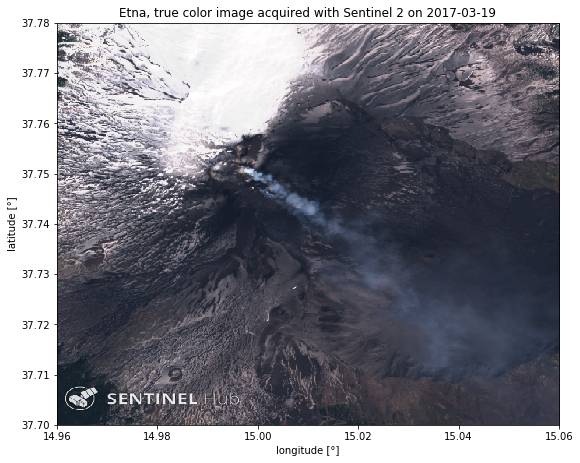

In [4]:
plot_image(wms_true_color_img[4], etna_bbox_web_mercator)
plt.title('Etna, true color image acquired with Sentinel 2 on '+ str(wms_true_color_dates[4].date()));

To be honest, it is difficult to see much on this image. We notice a white color, which is either snow or clouds. If we look more carefully we might notice a shade on right lower corner indicating that there is a mountain in the image. Knowing that it is Etna, we can recognize a crater and a smoke fuming out of crater. Lava is dark and it is thus impossible to distinguish it from soil or see it through the smoke.

But could we use lava's "hotness" to see it? Very hot materials on Earth surface can be seen by satellites not only because they reflect Sun's radiation but because the are hot enough (e.g. more than 500°C) so that their own radiation can also be detected by sensors on board of the satellite. To utilize this we will create a visualization based on data acquired in infra red part of electromagnetic spectrum (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial). We will use:
- Band 04 (B04), which measures radiation of electromagnetic waves with wavelengths around 665 nm
- Band 11 (B11), which measures radiation of electromagnetic waves with wavelengths around 1610 nm 
- Band 12 (B12), which measures radiation of electromagnetic waves with wavelengths around 2190 nm

To visualize these data, will use red color for image acquired with B12, green color for image acquired with B11 and blue color for image acquired with B04. Let check how that looks like:

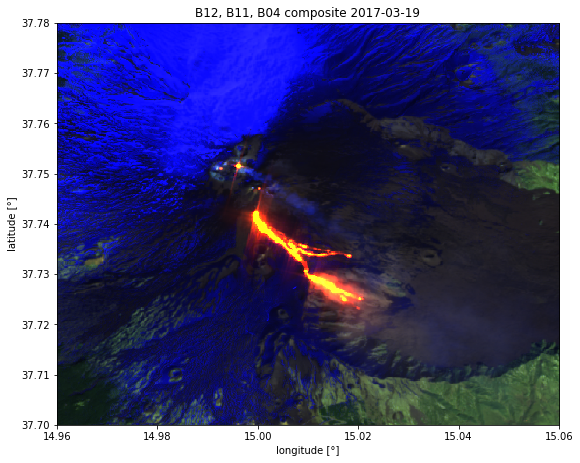

In [5]:
wms_bands_request = WmsRequest(data_folder='data',
                               layer='BANDS-S2-L1C',
                               bbox=etna_bbox,
                               time=('2017-02-27','2017-04-18'),
                               width=512,
                               image_format=MimeType.TIFF_d32f,
                               maxcc=0.7,
                               instance_id=INSTANCE_ID)

wms_bands_img = wms_bands_request.get_data(save_data=True)
wms_bands_dates = wms_bands_request.get_dates()

plot_image(wms_bands_img[4][:, :, [12, 11, 3]], etna_bbox_web_mercator, 2.5)
plt.title('B12, B11, B04 composite '+ str(wms_true_color_dates[4].date()));

The image is much different now. We can easily distinguish snow from smoke. More interestingly hot lava flow can now be nicely observed. It appears red and yellow due to high values in B12 (red color) and in B11 (green color). However, in nature lava would (still) be black (dark) as we saw in true color image.

Now that we know hot to visualize data in a useful way, let's put all images acquired during Etna's eruption together to gain some understanding of the dynamic of the phenomenon:

In [6]:
def draw_an_image(images, i):
    """
    This function will draw an image selected from the list of "images" for a given "date". 
    It is linked to dropdown list from which user can select image to be drawn.
    """
    
    plot_image(images[wms_bands_dates.index(dropdown_date.value)][:, :, [12, 11, 3]],etna_bbox_web_mercator, 2.5)

dropdown_date = widgets.Dropdown(
                                options=wms_bands_dates,
                                value=wms_bands_dates[4],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(draw_an_image, images=widgets.fixed(wms_bands_img), i=dropdown_date);

A Jupyter Widget

Quite nice, right? We can see the lava first flowed towards south-esat and then it turned to south-west.   However, there are some issues that deserve a comment:

1) Image from 27.2.2017 is very cloudy. Why is that, did we not requested only images with cloud coverage less than 70% (see maxcc=0.7 parameter of wms request above). 

2) Half of the image from 26.3.2017 is missing, since the area of interest is at the edge of acquisition swath.


So far we have used images squired from Sentinel 2 satellite. We could check if there are any available (and cloudless) images from other satellites, which could revealed additional information about the event. Landsat 8, which has similar sensors as Sentinel 2 on board, seems the most promising choice. Let's request the data:

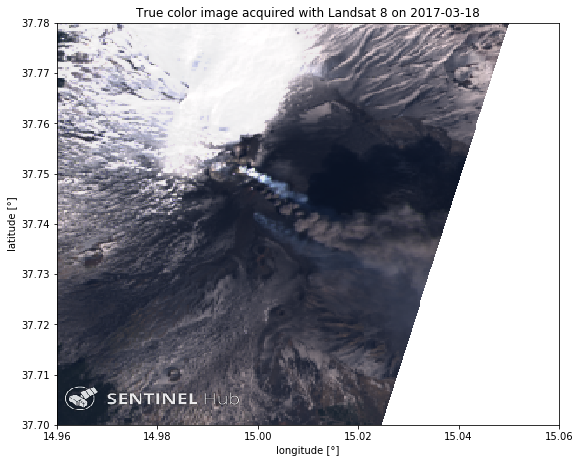

In [7]:
wms_true_color_request_l8 = WmsRequest(data_folder='data',
                                       data_source=DataSource.LANDSAT8,
                                        layer='TRUE-COLOR-L8',
                                        bbox=etna_bbox,
                                        time=('2017-02-27','2017-04-18'),
                                        width=512,
                                        maxcc=0.7,
                                        instance_id=INSTANCE_ID)

wms_true_color_request_img_l8 = wms_true_color_request_l8.get_data(save_data=True)
wms_true_color_dates_l8 = wms_true_color_request_l8.get_dates()

plot_image(wms_true_color_request_img_l8[-3],etna_bbox_web_mercator)
plt.title('True color image acquired with Landsat 8 on '+ str(wms_true_color_dates_l8[-3].date()));

In [8]:
wms_true_color_request_l8 = WmsRequest(data_folder='data',
                                       data_source=DataSource.LANDSAT8,
                                        layer='BANDS-L8',
                                        bbox=etna_bbox,
                                        time=('2017-02-27','2017-04-18'),
                                        width=1024,
                                        maxcc=0.7,
                                        image_format=MimeType.TIFF_d32f,
                                        instance_id=INSTANCE_ID)

wms_bands_request_img_l8 = wms_true_color_request_l8.get_data(save_data=True)
wms_bands_dates_l8 = wms_true_color_request_l8.get_dates()


def draw_an_image(images, i):
    """
    This function will draw an image selected from the list of "images" for a given "date". 
    It is linked to dropdown list from which user can select image to be drawn.
    """
    
    plot_image(images[wms_bands_dates_l8.index(dropdown_date.value)][:, :, [6, 5, 7]],etna_bbox_web_mercator, 2.5)

dropdown_date = widgets.Dropdown(
                                options=wms_bands_dates_l8,
                                value=wms_bands_dates_l8[0],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(draw_an_image, images=widgets.fixed(wms_bands_request_img_l8), i=dropdown_date);

A Jupyter Widget

## Previous Eruptions of Etna

Etna's eruptions in 2017 was of course not the only one. We searched through news about recent eruptions and checked if we can spot them in any of the satellite images. This is what we found:

1) Etna, image from Landsat 5 on 24.11.2006:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.7381&lng=14.9596&zoom=12&time=2006-11-24&preset=CUSTOM&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07" target="_blank">
 <img src="images/2006-11-24, Landsat 5 ESA, Custom script.jpg" alt="Drawing" style="width: 1000px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 5 on 24.11.2006 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.7381&lng=14.9596&zoom=12&time=2006-11-24&preset=CUSTOM&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07">EO Browser link</a>). </td>
</tr>
</table>

2) Etna, image from Landsat 8 on 3.12.2015:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74031&lng=14.98638&zoom=13&time=2015-12-03&preset=CUSTOM&datasource=Landsat%208%20USGS&layers=B07,B06,B04&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNioyLjUsQjA0KjIuNV07" target="_blank">
 <img src="images/2015-12-03, Landsat 8 USGS, Custom script.jpg" alt="Drawing" style="width: 1000px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 8 on 3.12.2015 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74031&lng=14.98638&zoom=13&time=2015-12-03&preset=CUSTOM&datasource=Landsat%208%20USGS&layers=B07,B06,B04&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNioyLjUsQjA0KjIuNV07">EO Browser link</a>). </td>
</tr>
</table>

## Otehr Resources to Check

- Volcanoes by ESA: https://www.esa.int/Our_Activities/Observing_the_Earth/Volcanoes
- Earth's Most Active Volcanoes on Satellite Watch by ESA: https://www.esa.int/Our_Activities/Observing_the_Earth/Earth_s_most_active_volcanoes_on_satellite_watch
- Volcanic Cloud Monitoring: https://volcano.ssec.wisc.edu/
- Sensing Remote Volcanoes by NASA: https://earthdata.nasa.gov/user-resources/sensing-our-planet/sensing-remote-volcanoes